In [1]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline

In [3]:
# read in 13F results
file_name = '/content/gdrive/My Drive/capstone/full database/Results_20160630_20200630.csv'
df = pd.read_csv(file_name)

In [4]:
n_investors = df.LGCYINVESTORID.nunique()
print('There are {} investors in 13F data.'.format(n_investors))

There are 6537 investors in 13F data.


In [5]:
# read in list of investors of interest
ls_investors = pd.read_csv('/content/gdrive/My Drive/capstone/full database/ListOfInvestor.csv').LgcyInvestorID.to_list()
print('There are {} investors which are we interested in.'.format(len(ls_investors)))

There are 229 investors which are we interested in.


In [6]:
# get those in 13F
df_sub = df.loc[df['LGCYINVESTORID'].isin(ls_investors),['INSTRID', 'COMNAME', 'LGCYINVESTORID', 'FULLNAME', 'HOLDDATE', 'SHSHLDVAL']]

# calculate the sum of SHSHLDVAL for each investor in each quarter
df_sub['SHSHLDVAL_Sum_ByQuarter'] = df_sub.groupby(['LGCYINVESTORID','HOLDDATE']).transform('sum').drop(['INSTRID', 'FULLNAME'], axis = 1)

# calculate the (13F only) pct of the SHSHLDVAL of each instrument in its investor's sum of SHSHLDVAL for each quarter 
# (i.e. revised version of 'PCTPORTFOLIO', so that sum up to 1)
df_sub['PCTPORTFOLIO_13F'] = df_sub['SHSHLDVAL'] / df_sub['SHSHLDVAL_Sum_ByQuarter']

In [7]:
vanguard_id = '2004260'

## Feature: Top 20% pct

Definition: the porportion of investment on top 20% of instruments.
This represents the concentration of the investment. In other words, if this score is low, the investor prefers  distributed investment. Otherwise, the investor prefers concentrated investment.

### Create features for the listed investors

In [8]:
def topPct(df, pct=0.2 ,k=10):
  n = len(df)
  k = int(pct * n)
  if k == 0:
    k = 1
  return sum(sorted(df)[-k:])/sum(df)

df_toppct = df_sub.groupby(['LGCYINVESTORID','FULLNAME','HOLDDATE']).agg({'SHSHLDVAL': topPct}).reset_index()

df_toppct.rename(columns={'SHSHLDVAL':'TOP20%SHSHLDVALpct'},inplace=True)

In [14]:
df_toppct.LGCYINVESTORID.nunique()

229

In [ ]:
# df_toppct.to_csv('/content/gdrive/My Drive/capstone/full database/TOP20%SHSHLDVALpct_20160630_20200630.csv',index=False)

### Compute DTW distance to vanguard


In [ ]:
! pip install tslearn
from tslearn.clustering import TimeSeriesKMeans
from tslearn.metrics import dtw, dtw_path
from tslearn.utils import to_time_series_dataset

In [12]:
def DTW_distance(invID_1, invID_2, inves_instr_pivot):
  # get the time-series holding data of the two investors for this instrument
  ts_inv_1 = inves_instr_pivot[inves_instr_pivot.LGCYINVESTORID==int(invID_1)]["TOP20%SHSHLDVALpct"]
  ts_inv_2 = inves_instr_pivot[inves_instr_pivot.LGCYINVESTORID==int(invID_2)]["TOP20%SHSHLDVALpct"]
  DTW_score = dtw(ts_inv_1, ts_inv_2)
  return DTW_score

In [16]:
investor_list = list(df_toppct.LGCYINVESTORID.unique())

distance_to_vanguard_list = []

for investor in investor_list:
  distance_to_vanguard = DTW_distance(investor, vanguard_id, inves_instr_pivot = df_toppct)
  distance_to_vanguard_list.append(distance_to_vanguard)


distance_to_vanguard_df = pd.DataFrame({
    'investor_id': investor_list,
    'TOP20%SHSHLDVALpct_distance_to_vanguard': distance_to_vanguard_list
})

In [17]:
merged = pd.merge(distance_to_vanguard_df, df_sub[['LGCYINVESTORID','FULLNAME']], 'left', left_on='investor_id', right_on='LGCYINVESTORID')
merged = merged.drop_duplicates(subset='LGCYINVESTORID').drop(['investor_id'], axis=1)
merged = merged.sort_values(by = ['TOP20%SHSHLDVALpct_distance_to_vanguard'])

In [ ]:
merged

,TOP20%SHSHLDVALpct_distance_to_vanguard,LGCYINVESTORID,FULLNAME
2169490,0.000000,2004260,"The Vanguard Group, Inc."
1130332,0.019160,2003003,"BlackRock Investment Management, LLC"
892525,0.020221,2002848,Columbia Threadneedle Investments (US)
459494,0.031636,2002506,BNY Mellon Asset Management
1763709,0.035371,2003354,"Wellington Management Company, LLP"
...,...,...,...
0,2.210230,2000264,"Lone Pine Capital, L.L.C."
2719794,2.211626,2275507,"Franklin Templeton Investimentos (Brasil), Ltda."
2716708,2.237419,2113769,"Legg Mason Asset Management (Japan) Co., Ltd."
3508495,2.338202,4040011,"Trian Fund Management, L.P."


In [20]:
# df_toppct.to_csv('/content/gdrive/My Drive/capstone_own/TOP20%SHSHLDVALpct_list.csv')
# merged.to_csv('/content/gdrive/My Drive/capstone_own/TOP20%SHSHLDVALpct_distance_to_vanguard_df.csv')

In [161]:
df_toppct

,LGCYINVESTORID,FULLNAME,HOLDDATE,TOP20%SHSHLDVALpct
0,2000264,"Lone Pine Capital, L.L.C.",2016-06-30 00:00:00,0.383612
1,2000264,"Lone Pine Capital, L.L.C.",2016-09-30 00:00:00,0.335504
2,2000264,"Lone Pine Capital, L.L.C.",2016-12-31 00:00:00,0.338615
3,2000264,"Lone Pine Capital, L.L.C.",2017-03-31 00:00:00,0.398285
4,2000264,"Lone Pine Capital, L.L.C.",2017-06-30 00:00:00,0.397128
...,...,...,...,...
3684,10233291,Lighthouse Wealth Management,2020-03-31 00:00:00,0.565941
3685,10233291,Lighthouse Wealth Management,2020-06-30 00:00:00,0.622533
3686,10235680,Quilter Cheviot Europe Ltd,2019-12-31 00:00:00,0.761452
3687,10235680,Quilter Cheviot Europe Ltd,2020-03-31 00:00:00,0.793639


## Feature: investment style, Industry, market of Investors' contacts

### Get description of different specialized code

We need to map with Own2Code(Type_=13) to get the description of the SpecCode.
SpecCat:
  - SpecCap == 1: Industry
    - Code in Own2Code: IS (201 different)
    - Code in data: xx
    - **Problem: IS193,IS194,IS195,IS196**
  - SpecCap == 3: Market Capitalization range in which the Investor Contact specializes
    - Code in Own2Code: MCS1 - MCS4
    - Code in data: 224 225 226 227
  - SpecCap == 4: Investment Style 
    - Code in Own2Code: ISS1 - ISS20(ISS19 not exists)
    - Code in data: 201 - 220 
    - **Problem: ISS19 not exists**

In [21]:
# read in contacts info for investors in 13F
contact_info = '/content/gdrive/My Drive/capstone/full database/ContactResults.csv'
contact_df = pd.read_csv(contact_info)

In [22]:
contact_df.head()

,LgcyInvestorId,LgcyPersonId,ContRole,ContRank,FirstName,LastName,Gender,SpecCat,SpecCode
0,2002008,9,Chief Investment Officer,1,Howard,Abner,M,1,95
1,2002008,9,Chief Investment Officer,1,Howard,Abner,M,4,202
2,2002008,9,Chief Investment Officer,1,Howard,Abner,M,4,208
3,2002008,9,Chief Investment Officer,1,Howard,Abner,M,4,216
4,2002008,9,Chief Investment Officer,1,Howard,Abner,M,4,217


In [23]:
# read in code table
code_file_name = '/content/gdrive/My Drive/capstone/full database/Own2Code.xlsx'
code_df = pd.read_excel(code_file_name)
code_df = code_df.fillna('9999999')
spec_code_df = code_df[code_df.Type_ == 13]

In [24]:
def explanation_spec(SpecCat, SpecCode):
  if pd.isna(SpecCat) or pd.isna(SpecCode):
    return 
  SpecCode = int(SpecCode)
  try:
    if SpecCat == 1:
      return 'Industry_' + spec_code_df[spec_code_df.Code == ('IS'+str(SpecCode))] ['Desc_'].values[0]
    elif SpecCat == 3:
      return 'Market_' + spec_code_df[spec_code_df.Code == ('MCS'+str(SpecCode-223))]['Desc_'].values[0]
    elif SpecCat == 4:
      return 'InvStyle_' + spec_code_df[spec_code_df.Code == ('ISS'+str(SpecCode-200))]['Desc_'].values[0]
  except:
    No_explanation.append((SpecCat, SpecCode))
    return 'No_explanation'

In [25]:
No_explanation = []
contact_df['SpecDesc_'] = contact_df.apply(lambda x: explanation_spec(x.SpecCat, x.SpecCode), axis=1)

In [26]:
# part of specCat don't have specDesc_
from collections import Counter
Counter(No_explanation)

Counter({(1, 193): 653,
         (1, 194): 15,
         (1, 195): 9,
         (1, 196): 273,
         (4, 219): 1195})

In [27]:
# Remove those with no explanation
contact_df = contact_df[contact_df['SpecDesc_'] != 'No_explanation']

### Aggregate for each investor

In [28]:
investor_style = pd.pivot_table(contact_df,index=['LgcyInvestorId'],columns=['SpecCat','SpecDesc_'], values=['LgcyPersonId'],aggfunc='count')
# investor_style.fillna(0,inplace=True)
investor_style.columns = investor_style.columns.droplevel()

In [29]:
print('{}({}) investors in 13F have contact info.'.format(len(investor_style), len(investor_style)/n_investors))

6302(0.9640507878231604) investors in 13F have contact info.


In [30]:
# contact_df.groupby(['LgcyInvestorId','SpecCat','SpecDesc_']).agg({'LgcyPersonId':'count'}).reset_index().to_csv('investstyle.csv')

### Create features for the listed investors

In [31]:
investor_style_sub = investor_style[investor_style.index.isin(ls_investors)]

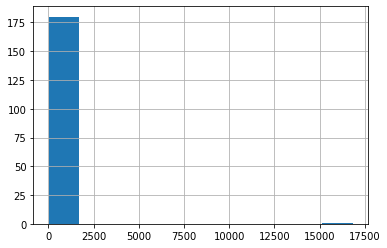

In [32]:
# whether we need to do tf-idf
investor_style_sub[1].sum(axis=0).hist()

In [33]:
investor_style_sub[1].sum(axis=0).sort_values()

SpecDesc_
Industry_Oil & Gas (Domestic Integ        3.0
Industry_Oil & Gas (Refining & Mkt        4.0
Industry_Airlines                         4.0
Industry_Services (Commercial Cons        4.0
Industry_Broadcasting (TV,Radio,Ca        4.0
                                       ...   
Industry_Paper & Forest Products        931.0
Industry_Machinery                     1028.0
Industry_Household Products (Non-D     1118.0
Industry_Health Care                   1355.0
Industry_Retail Stores-Food Chains    16840.0
Length: 181, dtype: float64

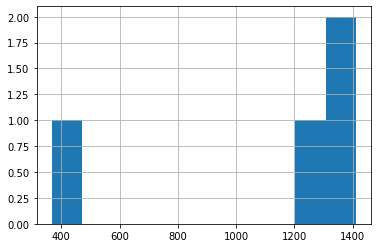

In [34]:
# whether we need to do tf-idf
investor_style_sub[3].sum(axis=0).hist()

In [35]:
investor_style_sub[3].sum(axis=0).sort_values()

SpecDesc_
Market_Micro Cap     367.0
Market_Mid Cap      1270.0
Market_Large Cap    1312.0
Market_Small Cap    1412.0
dtype: float64

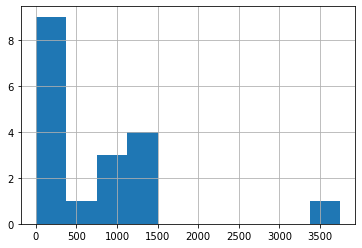

In [36]:
# whether we need to do td-idf
investor_style_sub[4].sum(axis=0).hist()

In [37]:
investor_style_sub[4].sum(axis=0).sort_values()

SpecDesc_
InvStyle_Technicals                  0.0
InvStyle_Private Equity             23.0
InvStyle_Quantitative               24.0
InvStyle_Growth                     29.0
InvStyle_Social Awareness           65.0
InvStyle_Sector Rotational          68.0
InvStyle_Venture Capital            89.0
InvStyle_Shareholder Activist      186.0
InvStyle_Special Situations        197.0
InvStyle_GARP                      734.0
InvStyle_Index                     930.0
InvStyle_Short Selling             990.0
InvStyle_Value                    1083.0
InvStyle_Arbitrage                1236.0
InvStyle_Income                   1242.0
InvStyle_Aggres. Gr.              1332.0
InvStyle_Convertible Arbitrage    1423.0
InvStyle_Emerging Markets         3749.0
dtype: float64

In [38]:
# compute weight, use idf
industry_weight = np.log(len(investor_style_sub) / (investor_style_sub[1].count(axis=0) + 1))
invStyle_weight = np.log(len(investor_style_sub) / (investor_style_sub[4].count(axis=0) + 1))

In [39]:
# normalize
def normalize(df):
  return df.div(df.sum(axis=1),axis=0).fillna(0)

industry_sub = normalize(investor_style_sub[1])
invStyle_sub = normalize(investor_style_sub[4])

In [40]:
industry_sub

SpecDesc_,Industry_Aerospace/Defense,Industry_Agricultural Products,Industry_Air Freight,Industry_Airlines,Industry_Aluminum,Industry_Auto Parts & Equipment,Industry_Automobiles,Industry_Autos/Auto Parts,Industry_Banks & Thrifts,Industry_Banks (Major Regional),Industry_Banks (Money Center),Industry_Banks (Regional),Industry_Beverages (Alcoholic),Industry_Beverages (Non-Alcoholic),Industry_Biofuels,Industry_Biotechnology,"Industry_Broadcasting (TV,Radio,Ca",Industry_Building Materials,Industry_Business Cyclicals,Industry_Business Staples,Industry_Cellular/Wireless Telecom,Industry_Chemicals,Industry_Clean technology,Industry_Communication Services,Industry_Communications Equipment,Industry_Computer Hardware,Industry_Computer Services,Industry_Computer Software,Industry_Computers (Networking),Industry_Computers (Peripherals),Industry_Consumer (Jewelry/Novelti,Industry_Consumer Cyclicals,Industry_Consumer Discretionary,Industry_Consumer Electronics,Industry_Consumer Finance,Industry_Consumer Staples,Industry_Containers-Metal & Glass,Industry_Containers/Packaging (Pap,Industry_Distributors (Durables),Industry_Distributors (Food & Heal,...,Industry_Renewable Energy,Industry_Restaurants,Industry_Retail,Industry_Retail (Building Supplies,Industry_Retail (Computers/Electro,Industry_Retail (Discounters/Offpr,Industry_Retail (Footwear),Industry_Retail (Home Items),Industry_Retail (Home Shopping/Cat,Industry_Retail Specialty-Apparel,Industry_Retail Stores-Dept Stores,Industry_Retail Stores-Drug Store,Industry_Retail Stores-Food Chains,Industry_Retail Stores-Gen Mer Cha,Industry_Retail-Specialty,Industry_Savings & Loan Companies,Industry_Semiconductors,Industry_Services (Advertising/Mkt,Industry_Services (Commercial Cons,Industry_Services (Employment),Industry_Services (Facils/Enviromn,Industry_Services (Payroll Process,Industry_Services (Rentals),Industry_Shipping,Industry_Specialty Communications,Industry_Steel,Industry_Technology,Industry_Telecommunication Service,Industry_Telephone (Local),Industry_Telephone-Local,Industry_Telephone-Long Distance,Industry_Textiles,Industry_Tobacco,Industry_Transportation,Industry_Truckers,Industry_Trucks & Parts,Industry_Utilities,Industry_Waste Management,Industry_Water Technology,Industry_Water Utilities
LgcyInvestorId,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2000264,0.018692,0.037383,0.0,0.0,0.000000,0.009346,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.037383,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.00,0.00000,0.037383,0.000000,0.000000,0.037383,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.028037,0.000000,0.000000,0.0,...,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.00000,0.000000,0.028037,0.0,0.037383,0.252336,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.0,0.000000,0.018692,0.000000,0.000000,0.0,0.037383,0.000000,0.0,0.000000,0.000000
2001934,0.016563,0.016563,0.0,0.0,0.000000,0.006211,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.018634,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.006211,0.004141,0.0,0.00,0.00000,0.016563,0.000000,0.000000,0.018634,0.0,0.000000,0.004141,0.0,0.000000,0.000000,0.006211,0.006211,0.000000,0.000000,0.0,...,0.0,0.018634,0.000000,0.0,0.008282,0.000000,0.000000,0.00207,0.000000,0.008282,0.0,0.018634,0.320911,0.004141,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00207,0.000000,0.0,0.000000,0.016563,0.000000,0.000000,0.0,0.018634,0.008282,0.0,0.002070,0.000000
2001935,0.009174,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.00,0.00000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.009174,0.000000,0.000000,0.0,...,0.0,0.009174,0.000000,0.0,0.000000,0.000

### compute distance to vanguard

#### Cosine distance

In [ ]:
from sklearn.metrics.pairwise import cosine_similarity, euclidean_distances
def cosine_distance(invID_1, invID_2, inves_pivot, dict_IDF=None):
  try:
    n_features = len(inves_pivot.columns)
    if dict_IDF is not None:
      weight = dict_IDF.to_numpy()
    else:
      weight = np.ones((n_features,)) 
    x_1 = inves_pivot.loc[invID_1,:].to_numpy().reshape((1,-1)) * weight
    x_2 = inves_pivot.loc[invID_2,:].to_numpy().reshape((1,-1)) * weight
    
    return cosine_similarity(x_1,x_2)[0][0]
  except:
    print(invID_1, invID_2)

In [ ]:
def euclidean_distance(invID_1, invID_2, inves_pivot, dict_IDF=None):
  try:
    n_features = len(inves_pivot.columns)
    if dict_IDF is not None:
      weight = dict_IDF.to_numpy()
    else:
      weight = np.ones((n_features,)) 
    x_1 = inves_pivot.loc[invID_1,:].to_numpy().reshape((1,-1)) * weight
    x_2 = inves_pivot.loc[invID_2,:].to_numpy().reshape((1,-1)) * weight
    return euclidean_distances(x_1,x_2)[0][0]
  except:
    print(invID_1, invID_2)

In [ ]:
investor_list = list(investor_style_sub.index)

industry_distance_to_vanguard_list = []
invStyle_distance_to_vanguard_list = []
for investor in investor_list:
  industry_distance_to_vanguard = cosine_distance(investor, int(vanguard_id), inves_pivot = industry_sub)
  industry_distance_to_vanguard_list.append(industry_distance_to_vanguard)
  invStyle_distance_to_vanguard = cosine_distance(investor, int(vanguard_id), inves_pivot = invStyle_sub)
  invStyle_distance_to_vanguard_list.append(invStyle_distance_to_vanguard)


distance_to_vanguard_df = pd.DataFrame({
    'investor_id': investor_list,
    'industry_distance_to_vanguard': industry_distance_to_vanguard_list,
    'invStyle_distance_to_vanguard': invStyle_distance_to_vanguard_list
})

In [ ]:
merged = pd.merge(distance_to_vanguard_df, df_sub[['LGCYINVESTORID','FULLNAME']], 'left', left_on='investor_id', right_on='LGCYINVESTORID')
merged = merged.drop_duplicates(subset='LGCYINVESTORID').drop(['investor_id'], axis=1)
merged = merged.sort_values(by=['industry_distance_to_vanguard','invStyle_distance_to_vanguard'])

In [ ]:
merged.to_csv('/content/gdrive/My Drive/capstone_own/style_cos_distance_to_vanguard_df.csv')

In [ ]:
merged

,industry_distance_to_vanguard,invStyle_distance_to_vanguard,LGCYINVESTORID,FULLNAME
2911674,0.220084,0.688153,2487483,Lindsell Train Limited
2150224,0.375110,0.734062,2004000,"Nomura Asset Management Co., Ltd."
2497341,0.523384,0.103385,2006020,"OrbiMed Advisors, LLC"
2719894,0.622938,0.380625,2380201,Edward Jones
3415233,0.652326,0.836576,2655110,Invesco Capital Management LLC
...,...,...,...,...
325355,0.984012,0.698539,2002451,AllianceBernstein L.P.
3141735,0.985456,0.629916,2575181,"Neuberger Berman, LLC"
2030660,0.987668,0.803581,2003800,Legal & General Investment Management Ltd.
2131946,0.990293,0.761265,2003828,Pictet Asset Management Ltd.


Text(0.5, 1.0, 'investor distance to vanguard')

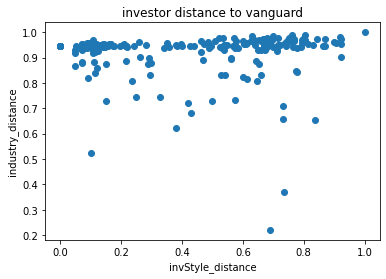

In [ ]:
plt.scatter(merged.invStyle_distance_to_vanguard, merged.industry_distance_to_vanguard)
plt.xlabel('invStyle_distance')
plt.ylabel('industry_distance')
plt.title('investor distance to vanguard')

In [ ]:
investor_list = list(investor_style_sub.index)

industry_distance_to_vanguard_list = []
invStyle_distance_to_vanguard_list = []
for investor in investor_list:
  industry_distance_to_vanguard = cosine_distance(investor, int(vanguard_id), inves_pivot = industry_sub, dict_IDF=industry_weight)
  industry_distance_to_vanguard_list.append(industry_distance_to_vanguard)
  invStyle_distance_to_vanguard = cosine_distance(investor, int(vanguard_id), inves_pivot = invStyle_sub,dict_IDF=invStyle_weight)
  invStyle_distance_to_vanguard_list.append(invStyle_distance_to_vanguard)


weighted_distance_to_vanguard_df = pd.DataFrame({
    'investor_id': investor_list,
    'industry_distance_to_vanguard': industry_distance_to_vanguard_list,
    'invStyle_distance_to_vanguard': invStyle_distance_to_vanguard_list
})

In [ ]:
weighted_merged = pd.merge(weighted_distance_to_vanguard_df, df_sub[['LGCYINVESTORID','FULLNAME']], 'left', left_on='investor_id', right_on='LGCYINVESTORID')
weighted_merged = weighted_merged.drop_duplicates(subset='LGCYINVESTORID').drop(['investor_id'], axis=1)
weighted_merged = weighted_merged.sort_values(by=['industry_distance_to_vanguard','invStyle_distance_to_vanguard'])

In [ ]:
weighted_merged

,industry_distance_to_vanguard,invStyle_distance_to_vanguard,LGCYINVESTORID,FULLNAME
2611872,0.000127,0.126564,2007217,Renaissance Technologies LLC
204182,0.015278,0.000000,2002019,Berkshire Hathaway Inc.
3628665,0.015278,0.000000,5844860,Polygon Management Ltd.
3680758,0.015278,0.000000,6129655,Park Avenue Securities LLC
3685087,0.015278,0.000000,6139212,Standard Life Investments (Corporate Funds) Ltd
...,...,...,...,...
2003094,0.835837,0.649826,2003716,Janus Henderson Investors
1619997,0.838554,0.942628,2003245,State Street Global Advisors (US)
1763709,0.851147,0.559571,2003354,"Wellington Management Company, LLP"
1946094,0.861712,0.752807,2003671,BlackRock Advisors (UK) Limited


In [ ]:
weighted_merged.to_csv('/content/gdrive/My Drive/capstone_own/weighted_style_cos_distance_to_vanguard_df.csv')

#### Euclidean distance

In [ ]:
investor_list = list(investor_style_sub.index)

industry_distance_to_vanguard_list = []
invStyle_distance_to_vanguard_list = []
for investor in investor_list:
  industry_distance_to_vanguard = euclidean_distance(investor, int(vanguard_id), inves_pivot = industry_sub)
  industry_distance_to_vanguard_list.append(industry_distance_to_vanguard)
  invStyle_distance_to_vanguard = euclidean_distance(investor, int(vanguard_id), inves_pivot = invStyle_sub)
  invStyle_distance_to_vanguard_list.append(invStyle_distance_to_vanguard)


distance_to_vanguard_df = pd.DataFrame({
    'investor_id': investor_list,
    'industry_distance_to_vanguard': industry_distance_to_vanguard_list,
    'invStyle_distance_to_vanguard': invStyle_distance_to_vanguard_list
})

In [ ]:
merged = pd.merge(distance_to_vanguard_df, df_sub[['LGCYINVESTORID','FULLNAME']], 'left', left_on='investor_id', right_on='LGCYINVESTORID')
merged = merged.drop_duplicates(subset='LGCYINVESTORID').drop(['investor_id'], axis=1)
merged = merged.sort_values(by=['industry_distance_to_vanguard','invStyle_distance_to_vanguard'])

In [ ]:
merged.to_csv('/content/gdrive/My Drive/capstone_own/style_euclidean_distance_to_vanguard_df.csv')

Text(0.5, 1.0, 'investor distance to vanguard')

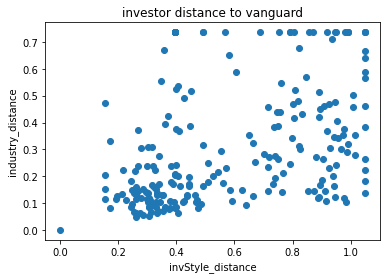

In [ ]:
plt.scatter(merged.invStyle_distance_to_vanguard, merged.industry_distance_to_vanguard)
plt.xlabel('invStyle_distance')
plt.ylabel('industry_distance')
plt.title('investor distance to vanguard')

In [ ]:
investor_list = list(investor_style_sub.index)

industry_distance_to_vanguard_list = []
invStyle_distance_to_vanguard_list = []
for investor in investor_list:
  industry_distance_to_vanguard = euclidean_distance(investor, int(vanguard_id), inves_pivot = industry_sub, dict_IDF=industry_weight)
  industry_distance_to_vanguard_list.append(industry_distance_to_vanguard)
  invStyle_distance_to_vanguard = euclidean_distance(investor, int(vanguard_id), inves_pivot = invStyle_sub,dict_IDF=invStyle_weight)
  invStyle_distance_to_vanguard_list.append(invStyle_distance_to_vanguard)


weighted_distance_to_vanguard_df = pd.DataFrame({
    'investor_id': investor_list,
    'industry_distance_to_vanguard': industry_distance_to_vanguard_list,
    'invStyle_distance_to_vanguard': invStyle_distance_to_vanguard_list
})

In [ ]:
weighted_merged = pd.merge(weighted_distance_to_vanguard_df, df_sub[['LGCYINVESTORID','FULLNAME']], 'left', left_on='investor_id', right_on='LGCYINVESTORID')
weighted_merged = weighted_merged.drop_duplicates(subset='LGCYINVESTORID').drop(['investor_id'], axis=1)
weighted_merged = weighted_merged.sort_values(by=['industry_distance_to_vanguard','invStyle_distance_to_vanguard'])

In [ ]:
weighted_merged

,industry_distance_to_vanguard,invStyle_distance_to_vanguard,LGCYINVESTORID,FULLNAME
2169490,1.862645e-09,0.000000,2004260,"The Vanguard Group, Inc."
1619997,4.321215e-02,0.105101,2003245,State Street Global Advisors (US)
1763709,4.337680e-02,0.261864,2003354,"Wellington Management Company, LLP"
3141735,4.371766e-02,0.289995,2575181,"Neuberger Berman, LLC"
325355,4.410214e-02,0.257961,2002451,AllianceBernstein L.P.
...,...,...,...,...
2497341,2.480347e-01,0.644222,2006020,"OrbiMed Advisors, LLC"
3333009,2.617951e-01,0.418195,2620417,"Brookfield Asset Management, Inc."
3628883,2.913952e-01,0.589341,5915225,Natixis Assurances
1388535,3.368889e-01,0.289639,2003121,"Virtus Investment Advisers, Inc."


In [ ]:
weighted_merged.to_csv('/content/gdrive/My Drive/capstone_own/weighted_style_euclidean_distance_to_vanguard_df.csv')

### K-means

In [101]:
from sklearn.cluster import KMeans

km = KMeans(n_clusters=2)
predict = km.fit_predict(invStyle_sub)

In [105]:
invStyle_sub.columns

Index(['InvStyle_Aggres. Gr.', 'InvStyle_Arbitrage',
       'InvStyle_Convertible Arbitrage', 'InvStyle_Emerging Markets',
       'InvStyle_GARP', 'InvStyle_Growth', 'InvStyle_Income', 'InvStyle_Index',
       'InvStyle_Private Equity', 'InvStyle_Quantitative',
       'InvStyle_Sector Rotational', 'InvStyle_Shareholder Activist',
       'InvStyle_Short Selling', 'InvStyle_Social Awareness',
       'InvStyle_Special Situations', 'InvStyle_Technicals', 'InvStyle_Value',
       'InvStyle_Venture Capital'],
      dtype='object', name='SpecDesc_')

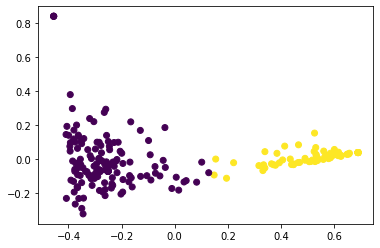

In [106]:
# PCA visualization
from sklearn.decomposition import PCA
pca = PCA(n_components=2)
pca_x = pca.fit_transform(invStyle_sub)
plt.scatter(pca_x[:,0],pca_x[:,1],c=predict)

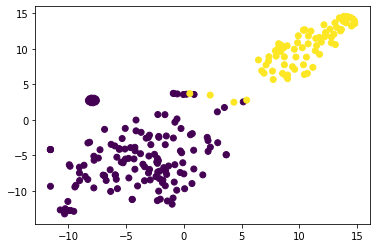

In [104]:
# TSNE visualization
from sklearn.manifold import TSNE
tsne = TSNE(n_components=2)
x = tsne.fit_transform(invStyle_sub)
plt.scatter(x[:,0],x[:,1],c=predict)
plt.title("Investment Style clustering")

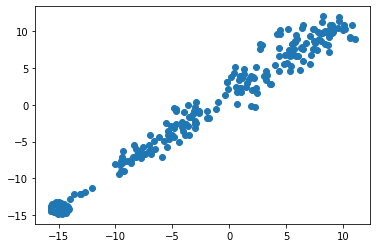

In [100]:
plt.scatter(x[:,0],x[:,1])

In [146]:
# evaluation
invStyle_sub_res = invStyle_sub.copy()
invStyle_sub_res['kmeans_cluster'] = predict

In [124]:
invStyle_sub_res.to_csv('/content/gdrive/My Drive/capstone_own/invStyle_list.csv')

In [125]:
# convert pivot table to dataframe so that the data could be used for tableau
# invStyle_sub_res.melt(ignore_index=False).reset_index().to_csv('/content/gdrive/My Drive/capstone_own/invStyle_list_table.csv')

#### weighted k-means

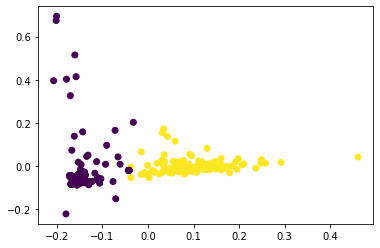

In [154]:
km = KMeans(n_clusters=2)
predict_weighted = km.fit_predict(invStyle_sub * invStyle_weight)


# PCA visualization

pca = PCA(n_components=2)
pca_x_weighted = pca.fit_transform(invStyle_sub * invStyle_weight)
plt.scatter(pca_x_weighted[:,0],pca_x_weighted[:,1],c=predict_weighted)

In [159]:
# evaluation
invStyle_sub_res['kmeans_cluster_weighted'] = 1- predict_weighted

In [160]:
sum(invStyle_sub_res['kmeans_cluster'] == invStyle_sub_res['kmeans_cluster_weighted'])

205

In [ ]:
# invStyle_sub_res_weighted.to_csv('/content/gdrive/My Drive/capstone_own/invStyle_list.csv')

## Aggregate the results

In [128]:

df_1 = pd.read_csv('/content/gdrive/My Drive/capstone_own/TOP20%SHSHLDVALpct_distance_to_vanguard_df.csv',index_col=0)
df_2 = pd.read_csv('/content/gdrive/My Drive/capstone_own/style_cos_distance_to_vanguard_df.csv',index_col=0)
df_3 = pd.read_csv('/content/gdrive/My Drive/capstone_own/weighted_style_cos_distance_to_vanguard_df.csv',index_col=0)
df_4 = pd.read_csv('/content/gdrive/My Drive/capstone_own/style_euclidean_distance_to_vanguard_df.csv',index_col=0)
df_5 = pd.read_csv('/content/gdrive/My Drive/capstone_own/weighted_style_euclidean_distance_to_vanguard_df.csv',index_col=0)

In [130]:
df_investstyle_cos = pd.merge(df_2,df_3, on=['LGCYINVESTORID','FULLNAME'],suffixes=('','_weighted'))
df_investstyle_euc = pd.merge(df_4,df_5, on=['LGCYINVESTORID','FULLNAME'],suffixes=('','_weighted'))
df_investstyle = pd.merge(df_investstyle_cos,df_investstyle_euc,on=['LGCYINVESTORID','FULLNAME'],suffixes=('_cos','_euclidean'))
df_feature = pd.merge(df_1,df_investstyle,on=['LGCYINVESTORID','FULLNAME'])

In [132]:
df_feature[['LGCYINVESTORID', 'FULLNAME', 'TOP20%SHSHLDVALpct_distance_to_vanguard',
       'industry_distance_to_vanguard_cos',
       'invStyle_distance_to_vanguard_cos',
       'industry_distance_to_vanguard_weighted_cos',
       'invStyle_distance_to_vanguard_weighted_cos',
       'industry_distance_to_vanguard_euclidean',
       'invStyle_distance_to_vanguard_euclidean',
       'industry_distance_to_vanguard_weighted_euclidean',
       'invStyle_distance_to_vanguard_weighted_euclidean']].to_csv('/content/gdrive/My Drive/capstone_own/distance_to_vanguard_df.csv')

In [133]:
df_feature[['LGCYINVESTORID', 'FULLNAME', 'TOP20%SHSHLDVALpct_distance_to_vanguard',
       'industry_distance_to_vanguard_cos',
       'invStyle_distance_to_vanguard_cos',
       'industry_distance_to_vanguard_weighted_cos',
       'invStyle_distance_to_vanguard_weighted_cos',
       'industry_distance_to_vanguard_euclidean',
       'invStyle_distance_to_vanguard_euclidean',
       'industry_distance_to_vanguard_weighted_euclidean',
       'invStyle_distance_to_vanguard_weighted_euclidean']].to_csv('/content/gdrive/My Drive/capstone/full database/investstyle_concentration_distance_to_vanguard.csv')